In [1]:
import numpy as np
import sklearn
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 100
%matplotlib inline

# Task 

Create a insurance pricing model that consists of two submodels: Frequency (F), and Severity (S), such that Price(P) will be P = FS

## Dataset
Major French car insurer and has been enriched with geographic information

**id_policy** unique identifier

<span style="color:blue">Blue for binary variables</span>

### Policy Related

**polbonus** starts at 1 for young drivers, decreases by 5% every year to a minimum of 0.5, increases by 25% every 
time a claim is made up to a maximum of 3.5 
<span style="color:red"> Min max this from 0-1 ?</span>



**polcoverage** -  Mini, Median1, Median2 and Maxi, in this order. Mini policies coveronly Third Party Liability claims, whereas Maxi policies covers all claims, including Damage, Theft, WindshieldBreaking, Assistance, etc. <span style="color:red"> Encode from 1 to 4 or one hot encode ?</span>

**polduration** - how old the policy is 

**pol_sit_duration** - how old the currentpolicy is

**pol_pay_freq** - biannual, quarterly, yearly, monthly - need to give an annual quote

<span style="color:blue">**pol_payd**</span> - Is it a mileage based policy

**pol_usage** - work/private, retired, professional, all trips

**pol_insee_code** - 5 digit alphanumeric code to identify communes and departments in france
   * commune_code
   * canton_code
   * city_destrict_code
   * regional_department_code

### Driver Related
<span style="color:blue"> **drv_drv2** </span> - is there a secondary driver on contract

**drv_age1** - age of first driver in years

**drv_age2** - age of second driver in years

<span style="color:blue"> **drv_sex1** </span> - sex of driver 1 (in actuality sex cannot be used for pricing by EU law)

**drv_sex2** - sex of driver 2

**drv_age_lic1** - Age of first driver's license in years

**drv_age_lic2** - Age of second driver's license in years



### Vehicle related

**vh_age**

**vh_cyl** - engine cyllinder displacement

**vh_din** - engine power

<span style="color:blue"> **vh_fuel** </span> -  kind of fuel, group into diesel vs gasoline & hybrid

**vh_make**

**vh_model**

**vh_sale_begin**

**vh_sale_end**

**vh_speed**

**vh_type**

**vh_value**

**vh_weight**


### Location Related

**town_mean_altitude**

**town_mean_surface_area**

**pol_insee_code** - 5 digit alphanumeric code to identify communes and departments in france
   * commune_code
   * canton_code
   * city_destrict_code
   * regional_department_code


### Targets

**made_claim** - Binary 0, 1 for whether a claim has been made

**claim_amount** - amount of claim, if any was claimed

In [16]:
def transform(df):
    df2 = df.copy()
    #fill na for city data - 395 missing entries - categorical and numerical, for now assume they come from the most frequent town
    df2['commune_code'] = df2['commune_code'].fillna(df2['commune_code'].mode()[0])
    df2['canton_code'] = df2['canton_code'].fillna(df2['canton_code'].mode()[0])
    df2['city_district_code'] = df2['city_district_code'].fillna(df2['city_district_code'].mode()[0])
    df2['regional_department_code'] = df2['regional_department_code'].fillna(df2['regional_department_code'].mode()[0])
    df2['population'] = df2['population'].fillna(df2['population'].mode()[0])
    df2['town_mean_altitude'] = df2['town_mean_altitude'].fillna(df2['town_mean_altitude'].mode()[0])
    df2['town_surface_area'] = df2['town_surface_area'].fillna(df2['town_surface_area'].mode()[0])
#   

    
    
#     #impute or remove illogical values
    df2.loc[df2['vh_weight']==0,'vh_weight'] = df2['vh_weight'].median() # - 2959 missing entries - imputation doesnt give a better correlation
    df2 = df2.loc[df2['drv_age1']>=df2['drv_age_lic1']] # 32 missing entires; dropped
    df2 = df2.loc[df2['vh_cyl']>0] #3 missing entries
    df2.loc[df2['vh_value']==0,'vh_value'] = 18659 #from data exploration

    

#     #one hot encode categorical features; 
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_coverage'])],axis=1)
    df2.loc[df2['pol_usage']=='AllTrips','pol_usage'] = 'Professional' #- only 77 AllTrips; from data description it is similar to professional
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_usage'])],axis=1)
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_pay_freq'])],axis=1)

#     #binarize features
    df2['pol_payd'] = (df2['pol_payd'] == 'Yes') * 1 # Yes/ No
    df2['drv_drv2'] = (df2['drv_drv2'] == 'Yes') * 1 # Yes / No
    df2['tourism'] = (df2['vh_type'] == 'Tourism') * 1 #tourism or commerical
    df2['diesel'] = (df2['vh_fuel'] == 'Diesel') * 1 #also hybrids but very low representation - 62 hybrids
    df2['M'] = (df2['drv_sex1'] == 'M') * 1 #Male / Female
    
    df2['pol_bonus2'] = (df2['pol_bonus'] == 0.5) * 1
#     #ordinally encode policy coverage
    order = {'Mini':1,'Median2':2,'Median1':3,'Maxi':4}
    df2['order_pol_coverage'] = df['pol_coverage'].apply(lambda x : order[x])

    unwantedFeatures= ['id_policy','pol_coverage','pol_pay_freq','pol_usage','pol_insee_code','drv_sex1',
                   'drv_age2','drv_sex2','drv_age_lic2','vh_fuel','vh_make','vh_model','vh_type']+['commune_code','canton_code', 'city_district_code', 'regional_department_code']+['WorkPrivate','Yearly']#+['made_claim','claim_amount']#+['drv_drv2']
    
    y1 = df2['made_claim']
    y2 = df2['claim_amount']
    df2 = df2.drop(unwantedFeatures,axis=1)
    return y1, y2, df2



df = pd.read_csv("training_data.csv")
y1, y2, df2 = transform(df)
df2.head()

,pol_bonus,pol_duration,pol_sit_duration,pol_payd,drv_drv2,drv_age1,drv_age_lic1,vh_age,vh_cyl,vh_din,vh_sale_begin,vh_sale_end,vh_speed,vh_value,vh_weight,town_mean_altitude,town_surface_area,population,claim_amount,made_claim,Maxi,Median1,Median2,Mini,Professional,Retired,Biannual,Monthly,Quarterly,tourism,diesel,M,pol_bonus2,order_pol_coverage
0,0.5,36,6,0,0,77,55,15,1598,111,16,15,185,17517,1260.0,526.0,3216.0,4.8,0.0,0,1,0,0,0,0,1,1,0,0,1,0,1,1,4
1,0.5,15,5,0,1,52,33,12,2184,112,12,9,180,21500,1480.0,57.0,4912.0,141.3,0.0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,4
2,0.5,16,6,0,0,52,34,20,2496,112,32,19,130,23600,2931.0,257.0,4488.0,5.3,0.0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1
3,0.5,11,7,0,0,67,46,12,1149,75,14,12,170,13050,930.0,109.0,1339.0,61.2,0.0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,4
4,0.5,16,6,0,1,60,35,23,1905,93,23,18,185,17974,1035.0,24.0,1849.0,9.7,0.0,0,0,0,1,0,0,0,1,0,0,1,1,1,1,2


In [3]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, r2_score, roc_auc_score,roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
booleanFeatures = ['pol_payd','Professional','Retired','M','diesel','order_pol_coverage','tourism','pol_bonus2']#+['Maxi', 'Median1', 'Median2', 'Mini'] # omitted - + ['drv_drv2','vh_make','vh_model','canton_code','commune_code',city_district_code','regional_department_code','Biannual', 'Monthly','Quarterly']
numericFeatures = ['pol_duration', 'vh_din', 'pol_bonus', 'population', 'pol_sit_duration', 'vh_value', 'vh_sale_begin', 'vh_sale_end', 'vh_cyl', 'vh_speed', 'drv_age1', 'vh_weight', 'vh_age', 'drv_age_lic1'] #+ ['order_pol_coverage','town_surface_area','town_mean_altitude']


In [ ]:
#imputation 


# df2.corrwith(df2['vh_weight']).abs().sort_values(ascending=False)
# feats= ['vh_weight', 'vh_din', 'vh_value', 'vh_speed', 'vh_cyl']
# feats2 = ['vh_din', 'vh_value', 'vh_speed', 'vh_cyl']
# df3 = df2[feats].copy()


# df3.loc[df3['vh_weight']==0,'vh_weight']=np.nan
# X = df3.loc[df3['vh_weight'].isna()==False][feats2]
# X2 = ((X-X.mean())/X.std())
# y = df3.loc[df3['vh_weight'].isna()==False,'vh_weight']
# from sklearn.decomposition import PCA
# pca = PCA()
# X3 = pca.fit_transform(X2)
# pca.explained_variance_ratio_
# from sklearn.linear_model import LinearRegression,HuberRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.model_selection import cross_val_score

# knn = KNeighborsRegressor(n_neighbors=2)
# scores = cross_val_score(knn,X3,y,cv=3)
# print(scores.mean())
# knn.fit(X3,y)
# # df3['vh_weight3'] = knn.predict(X3)
# # lr.score(X,y)
# #0.9559060823508047 with feats; with PCA 0.9559322216070724
# X4 = df3.loc[df3['vh_weight'].isna()==True][feats2]
# X5 = ((X4-X.mean())/X.std())
# X5 = pca.transform(X5)
# df3['vh_weight3'] = df3['vh_weight']
# df3.loc[df3['vh_weight3'].isna()==True,'vh_weight3']=knn.predict(X5)


In [ ]:
#transformations

#log-scaling doesnt work on pol_sit_duration
#df2['pol_duration'] = (df2['pol_duration']-df2['pol_duration'].min())/((df2['pol_duration'].max()-df2['pol_duration'].min()))
#df2['pol_sit_duration'] = (df2['pol_sit_duration']-df2['pol_sit_duration'].min())/((df2['pol_sit_duration'].max()-df2['pol_sit_duration'].min()))
#df['drv_age1']((df2['drv_age1']-df2['drv_age1'].mean())/df2['drv_age1'].std())
#df['drv_age_lic1']((df2['drv_age_lic1']-df2['drv_age_lic1'].mean())/df2['drv_age_lic1'].std())
#df['log_vh_age'] = ((np.log(df['vh_age'])-np.log(df['vh_age']).mean())/np.log(df['vh_age']).std())
#df['log_vh_cyl'] = (np.log(df2['vh_cyl'])-np.log(df2['vh_cyl']).mean())/np.log(df2['vh_cyl']).std()
#df['log_vh_din'] = ((np.log(df2['vh_din'])-np.log(df2['vh_din']).mean())/np.log(df2['vh_din']).std())
#df['log_vh_sale_begin'] = ((np.log(df['vh_sale_begin'])-np.log(df['vh_sale_begin']).mean())/np.log(df['vh_sale_begin']).std())
#df['log_vh_sale_end'] = ((np.log(df['vh_sale_end'])-np.log(df['vh_sale_end']).mean())/np.log(df['vh_sale_end']).std())
#df2['vh_speed'] = ((df2['vh_speed']-df2['vh_speed'].mean())/df2['vh_speed'].std())
#df2['log_vh_value'] = ((np.log(df['vh_value'])-np.log(df['vh_value']).mean())/np.log(df['vh_value']).std())
#df2['log_vh_weight'] = ((np.log(df['vh_weight'])-np.log(df['vh_weight']).mean())/np.log(df['vh_weight']).std())



#not that useful - order_pol_pay_freq, monthly, yearly most importantp
# def pol_pay_freq(x):
#     order = {'Yearly':1,'Biannual':2,'Quarterly':4,'Monthly':12}
#     return order[x]

# df2['order_pol_pay_freq'] = df['pol_pay_freq'].apply(lambda x : pol_pay_freq(x))




# Univariate Plots

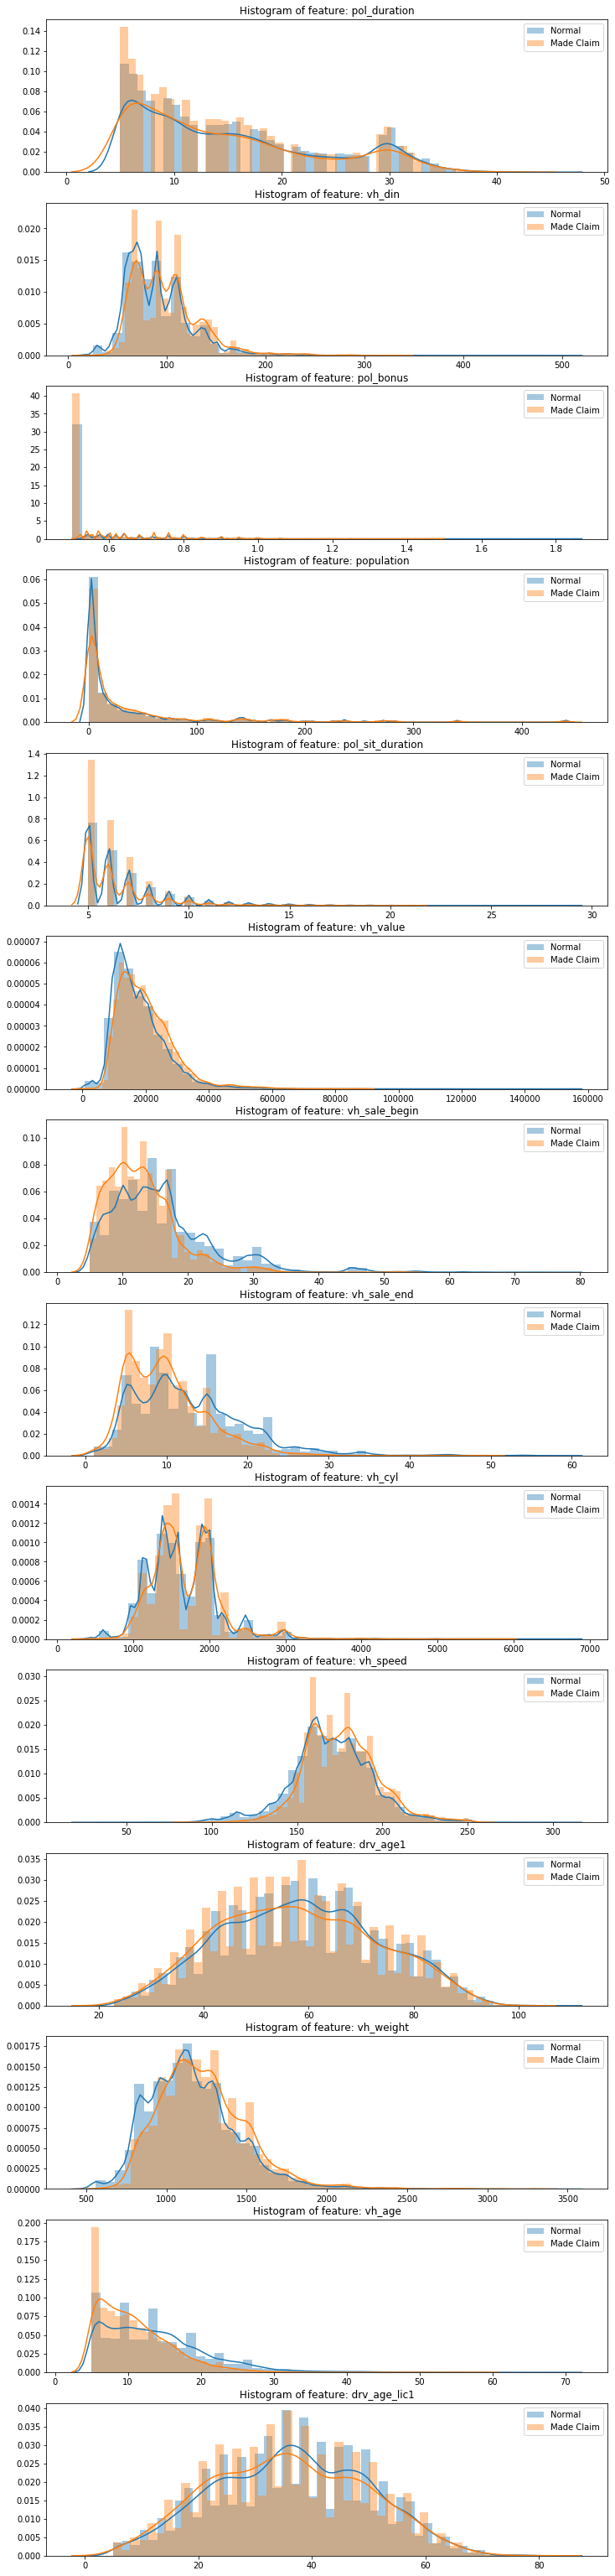

In [5]:
import matplotlib.gridspec as gridspec
plt.figure(figsize = (12, 120))
gs = gridspec.GridSpec(30, 1)
for i, cn in enumerate(df2[numericFeatures]):
    ax = plt.subplot(gs[i])    
    sns.distplot(df2[cn][df2['made_claim'] == 0], bins = 50, label = 'Normal')
    sns.distplot(df2[cn][df2['made_claim'] == 1], bins = 50, label = 'Made Claim')
    ax.set_xlabel('')
    ax.set_title('Histogram of feature: ' + str(cn))
    plt.legend()
plt.show()

# Categorical Features

In [10]:
#difference in mile based policy?
print(df.groupby('made_claim')['pol_payd'].value_counts(),"\n")
df.groupby('made_claim')['pol_payd'].value_counts()/df.groupby('made_claim')['pol_payd'].count()

made_claim  pol_payd
0           No          69065
            Yes          3091
1           No           7034
            Yes           230
Name: pol_payd, dtype: int64 



made_claim  pol_payd
0           No          0.957162
            Yes         0.042838
1           No          0.968337
            Yes         0.031663
Name: pol_payd, dtype: float64

In [14]:
#differences in sex?
print(df2.groupby('made_claim')['M'].value_counts(),"\n")
df2.groupby('made_claim')['M'].value_counts()/df2.groupby('made_claim')['M'].count()

made_claim  M
0           1    43476
            0    28649
1           1     4271
            0     2989
Name: M, dtype: int64 



made_claim  M
0           1    0.602787
            0    0.397213
1           1    0.588292
            0    0.411708
Name: M, dtype: float64

In [15]:
#differences in if there is a second driver?
print(df2.groupby('made_claim')['drv_drv2'].value_counts(),"\n")
print(df2.groupby('made_claim')['drv_drv2'].value_counts()/df2.groupby('made_claim')['drv_drv2'].count())

made_claim  drv_drv2
0           0           48426
            1           23699
1           0            4677
            1            2583
Name: drv_drv2, dtype: int64 

made_claim  drv_drv2
0           0           0.671418
            1           0.328582
1           0           0.644215
            1           0.355785
Name: drv_drv2, dtype: float64


In [18]:
#differences in policy coverage?
print(df2.groupby('made_claim')['order_pol_coverage'].value_counts(),"\n")
df2.groupby('made_claim')['order_pol_coverage'].value_counts()/df2.groupby('made_claim')['order_pol_coverage'].count()

made_claim  order_pol_coverage
0           4                     45330
            2                     13078
            3                      6944
            1                      6773
1           4                      5777
            2                       898
            3                       443
            1                       142
Name: order_pol_coverage, dtype: int64 



made_claim  order_pol_coverage
0           4                     0.628492
            2                     0.181324
            3                     0.096277
            1                     0.093906
1           4                     0.795730
            2                     0.123691
            3                     0.061019
            1                     0.019559
Name: order_pol_coverage, dtype: float64

In [19]:
#differences in policy payment frequency?
#assume none
print(df.groupby('made_claim')['pol_pay_freq'].value_counts(),"\n")
df.groupby('made_claim')['pol_pay_freq'].value_counts()/df.groupby('made_claim')['pol_pay_freq'].count()

made_claim  pol_pay_freq
0           Yearly          26222
            Monthly         23459
            Biannual        20436
            Quarterly        2039
1           Yearly           2539
            Monthly          2463
            Biannual         2074
            Quarterly         188
Name: pol_pay_freq, dtype: int64 



made_claim  pol_pay_freq
0           Yearly          0.363407
            Monthly         0.325115
            Biannual        0.283220
            Quarterly       0.028258
1           Yearly          0.349532
            Monthly         0.339069
            Biannual        0.285518
            Quarterly       0.025881
Name: pol_pay_freq, dtype: float64

In [20]:
print(df.groupby('made_claim')['pol_usage'].value_counts(),"\n")
df.groupby('made_claim')['pol_usage'].value_counts()/df.groupby('made_claim')['pol_usage'].count()

made_claim  pol_usage   
0           WorkPrivate     47798
            Retired         19314
            Professional     4979
            AllTrips           65
1           WorkPrivate      4643
            Retired          1900
            Professional      709
            AllTrips           12
Name: pol_usage, dtype: int64 



made_claim  pol_usage   
0           WorkPrivate     0.662426
            Retired         0.267670
            Professional    0.069003
            AllTrips        0.000901
1           WorkPrivate     0.639180
            Retired         0.261564
            Professional    0.097605
            AllTrips        0.001652
Name: pol_usage, dtype: float64

In [37]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
commune_code_corrs = pd.DataFrame(ohe.fit_transform(df2['commune_code'].values.reshape(-1,1)).todense()).corrwith(df2['made_claim']).abs().sort_values(ascending=False)
commune_code_corrs

808    0.015640
259    0.012058
821    0.011189
776    0.011189
828    0.011189
         ...   
222    0.000021
112    0.000016
145    0.000010
305    0.000007
225    0.000001
Length: 833, dtype: float64

In [39]:
ohe = OneHotEncoder()
canton_code_corrs = pd.DataFrame(ohe.fit_transform(df2['canton_code'].values.reshape(-1,1)).todense()).corrwith(df2['made_claim']).abs().sort_values(ascending=False)
canton_code_corrs

72    0.008702
32    0.008474
88    0.007989
67    0.007558
58    0.007263
        ...   
37    0.000170
29    0.000159
76    0.000085
78    0.000057
71    0.000045
Length: 94, dtype: float64

In [40]:
ohe = OneHotEncoder()
city_district_code_corrs = pd.DataFrame(ohe.fit_transform(df2['city_district_code'].values.reshape(-1,1)).todense()).corrwith(df2['made_claim']).abs().sort_values(ascending=False)
city_district_code_corrs

3    0.005975
8    0.004749
0    0.004056
2    0.003427
4    0.003377
7    0.002259
6    0.000516
5    0.000104
1    0.000095
dtype: float64

In [41]:
ohe = OneHotEncoder()
regional_department_code_corrs = pd.DataFrame(ohe.fit_transform(df2['regional_department_code'].values.reshape(-1,1)).todense()).corrwith(df2['made_claim']).abs().sort_values(ascending=False)
regional_department_code_corrs

16    0.009124
46    0.008189
49    0.008094
50    0.006689
54    0.005907
        ...   
68    0.000164
34    0.000145
25    0.000102
52    0.000080
91    0.000054
Length: 96, dtype: float64

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
vh_make_corrs = pd.DataFrame(ohe.fit_transform(df['vh_make'].values.reshape(-1,1)).todense()).corrwith(df['made_claim']).abs().sort_values(ascending=False)
vh_make_corrs

In [42]:
#differences in diesel?
print(df2.groupby('made_claim')['diesel'].value_counts(),"\n")
df2.groupby('made_claim')['diesel'].value_counts()/df2.groupby('made_claim')['diesel'].count()

made_claim  diesel
0           1         38777
            0         33348
1           1          4647
            0          2613
Name: diesel, dtype: int64 



made_claim  diesel
0           1         0.537636
            0         0.462364
1           1         0.640083
            0         0.359917
Name: diesel, dtype: float64

In [43]:
#differences in tourism?
print(df2.groupby('made_claim')['tourism'].value_counts(),"\n")
df2.groupby('made_claim')['tourism'].value_counts()/df2.groupby('made_claim')['diesel'].count()

made_claim  tourism
0           1          64865
            0           7260
1           1           6738
            0            522
Name: tourism, dtype: int64 



made_claim  tourism
0           1          0.899341
            0          0.100659
1           1          0.928099
            0          0.071901
dtype: float64

In [ ]:
print(df.groupby(['made_claim'])['vh_make'].value_counts())
df.groupby(['made_claim'])['vh_make'].value_counts()/df.groupby(['made_claim'])['vh_make'].count()

print(df.groupby(['made_claim'])['vh_model'].value_counts())
df.groupby(['made_claim'])['vh_model'].value_counts()/df.groupby(['made_claim'])['vh_model'].count()

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
vh_model_corrs = pd.DataFrame(ohe.fit_transform(df['vh_model'].values.reshape(-1,1)).todense()).corrwith(df['made_claim']).abs().sort_values(ascending=False)
vh_model_corrs

# Bivariate

In [ ]:
plt.scatter(df['pol_duration'],df['pol_sit_duration'],c=df['made_claim'],alpha=0.5)
plt.scatter(df['drv_age1'],df['drv_age_lic1'],c=df['made_claim'],alpha=0.5)

from sklearn.decomposition import PCA
pca = PCA()
ageFactors = ['pol_duration','pol_sit_duration','pol_bonus','drv_age1','drv_age_lic1']
X = pca.fit_transform(df[ageFactors])
plt.scatter(X[:,0],X[:,1],c=df['made_claim'],alpha=0.5)


contribution = [sorted(zip(ageFactors,np.abs(pca.components_[i])),key=(lambda k : k[1])) for i in range(len(ageFactors))]

plt.barh(list(dict(contribution[4]).keys()),list(dict(contribution[4]).values()))
# #low dimensional representation
# from sklearn.manifold import TSNE
# tsne = TSNE()
# X3 = tsne.fit_transform(X[[:1000]])
# plt.scatter(X3[:,0],X3[:,1],c=df2.iloc[:1000]['made_claim'])

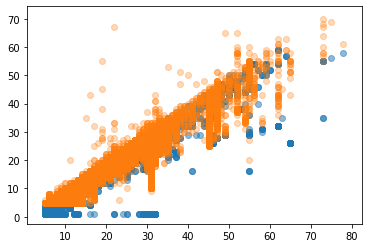

In [44]:
plt.scatter(df2['vh_sale_begin'],df2['vh_sale_end'],alpha=0.5)
plt.scatter(df2['vh_sale_begin'],df2['vh_age'],alpha=0.3)

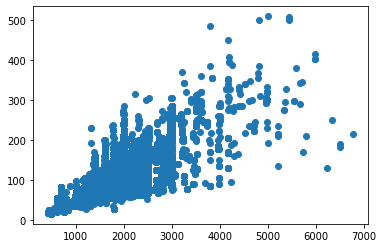

In [45]:
plt.scatter(df2['vh_cyl'],df2['vh_din'])

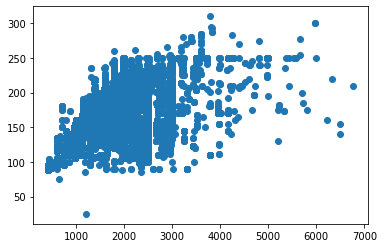

In [46]:
plt.scatter(df2['vh_cyl'],df2['vh_speed'])

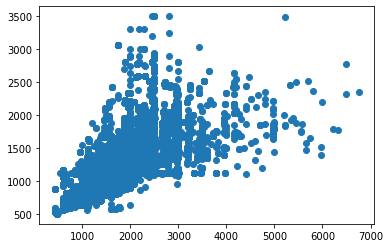

In [47]:
plt.scatter(df2['vh_cyl'],df2['vh_weight'])

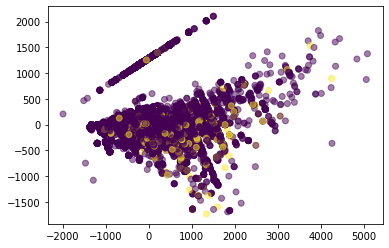

In [48]:
from sklearn.decomposition import PCA
pca = PCA()
# a = ['vh_age','vh_sale_begin','vh_sale_end']
X = pca.fit_transform(df[['vh_cyl','vh_din','vh_speed','vh_weight']])
plt.scatter(X[:,0],X[:,1],c=df['made_claim'],alpha=0.5)

# Correlations

In [5]:
#most correlated features
amountSpearmanCorrs = df2.corrwith(df2['claim_amount'],method='spearman').abs().sort_values(ascending=False)
frequencySpearmanCorrs = df2.corrwith(df2['made_claim'],method='spearman').abs().sort_values(ascending=False)
amountPearsonCorrs = df2.corrwith(df2['claim_amount'],method='pearson').abs().sort_values(ascending=False)
frequencyPearsonCorrs = df2.corrwith(df2['made_claim'],method='pearson').abs().sort_values(ascending=False)

In [6]:
frequencySpearmanCorrs

made_claim            1.000000
claim_amount          0.998470
vh_sale_begin         0.125124
vh_age                0.123323
vh_sale_end           0.122681
order_pol_coverage    0.104463
Maxi                  0.100666
vh_value              0.085406
vh_din                0.080440
Mini                  0.075998
vh_weight             0.074570
vh_speed              0.072166
diesel                0.059324
pol_sit_duration      0.048777
pol_bonus             0.048365
Median2               0.043618
Median1               0.034984
vh_cyl                0.034559
Professional          0.032648
population            0.028460
tourism               0.027878
pol_duration          0.022787
drv_age1              0.018752
drv_age_lic1          0.018709
drv_drv2              0.016662
pol_payd              0.016090
town_mean_altitude    0.011109
town_surface_area     0.010868
Monthly               0.008573
M                     0.008534
Quarterly             0.004146
Retired               0.003815
Biannual

In [94]:
from sklearn.feature_selection import mutual_info_classif
infos = mutual_info_classif(df2,y1)
dict(sorted(zip(list(df2.columns),infos),key = lambda k : k[1],reverse=True))

{'made_claim': 0.30601907862604405,
 'claim_amount': 0.30564713414458866,
 'order_pol_coverage': 0.014798666575405184,
 'tourism': 0.012514587995519522,
 'Maxi': 0.010715780246050688,
 'vh_age': 0.01050783543783984,
 'vh_value': 0.010458228604525166,
 'vh_sale_end': 0.010413539850316011,
 'vh_sale_begin': 0.009399312339316124,
 'diesel': 0.0076451203147647195,
 'vh_cyl': 0.007236382547455067,
 'pol_bonus': 0.007171898645367936,
 'vh_din': 0.006843671278853547,
 'vh_speed': 0.006751160484092855,
 'vh_weight': 0.006730212537593205,
 'pol_sit_duration': 0.0047740171644203855,
 'M': 0.004714285177071398,
 'Mini': 0.003757650980713345,
 'Monthly': 0.0025864600082605715,
 'pol_duration': 0.0023214510203526384,
 'pol_payd': 0.002009467081089511,
 'drv_drv2': 0.001970822421199392,
 'drv_age_lic1': 0.0016569645975037517,
 'town_mean_altitude': 0.0016058062644224158,
 'town_surface_area': 0.0016035936907259352,
 'Professional': 0.0011644220594029253,
 'Retired': 0.0010404253729794366,
 'Median2'

In [95]:
from sklearn.feature_selection import chi2
chisq = chi2(df2,y1)
dict(sorted(zip(list(df2.columns),chisq[0]),key = lambda k : k[1],reverse=True))

{'claim_amount': 87392712.67252073,
 'vh_value': 1890044.747461388,
 'made_claim': 72125.0,
 'vh_weight': 26546.28705002903,
 'vh_cyl': 9095.51611755462,
 'vh_din': 5230.570726440911,
 'vh_sale_begin': 4361.719666409953,
 'vh_age': 4189.174354557176,
 'vh_sale_end': 4107.840687747705,
 'town_mean_altitude': 2658.684357119328,
 'population': 2574.826534317264,
 'vh_speed': 1393.3909308901657,
 'Mini': 418.56152802372344,
 'Maxi': 286.5570434505969,
 'order_pol_coverage': 279.4832499292519,
 'town_surface_area': 200.5422288679848,
 'pol_sit_duration': 192.82586236650565,
 'pol_duration': 189.5659905765205,
 'diesel': 126.55744165664763,
 'Median2': 124.44470800782142,
 'drv_age_lic1': 121.75644374128635,
 'drv_age1': 99.18292618272082,
 'Median1': 88.11909038163982,
 'Professional': 78.47434808281268,
 'pol_payd': 19.69264055949104,
 'drv_drv2': 14.743184632446631,
 'tourism': 6.0478513609930475,
 'Monthly': 3.930297029823288,
 'M': 2.3041028167062065,
 'Quarterly': 1.3263150579148857,
 

In [96]:
from sklearn.feature_selection import f_classif
f = f_classif(df2,y1)
dict(sorted(zip(list(df2.columns),f[0]),key = lambda k : k[1],reverse=True))

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


{'made_claim': inf,
 'claim_amount': 10087.416676747409,
 'vh_age': 1165.0212299505313,
 'vh_sale_end': 1146.8904505247806,
 'vh_sale_begin': 1140.3520409514226,
 'order_pol_coverage': 859.8252832786734,
 'Maxi': 812.668279214822,
 'Mini': 461.15206696435905,
 'vh_value': 456.71273023433974,
 'vh_speed': 437.77373592739684,
 'vh_din': 409.02446609218106,
 'vh_weight': 390.14049377832555,
 'diesel': 280.3590253893903,
 'pol_sit_duration': 234.2562607079884,
 'Median2': 151.31900970453228,
 'pol_bonus': 128.03099961251797,
 'Median1': 97.27672558042023,
 'Professional': 84.70648945812357,
 'vh_cyl': 69.81877669796569,
 'tourism': 61.74119585768993,
 'pol_duration': 39.03424050283998,
 'drv_age1': 26.33161729624807,
 'drv_age_lic1': 24.70927157893388,
 'drv_drv2': 22.04551996777676,
 'population': 21.79865490317435,
 'pol_payd': 20.557237481893253,
 'town_mean_altitude': 9.401908616156772,
 'Monthly': 5.835453603598676,
 'M': 5.7816522984872645,
 'Quarterly': 1.364585371738343,
 'Retired'

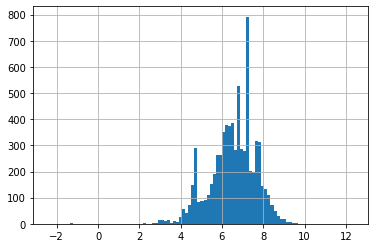

In [7]:
np.log(df2.loc[df2['made_claim']==1]['claim_amount']).hist(bins=100)

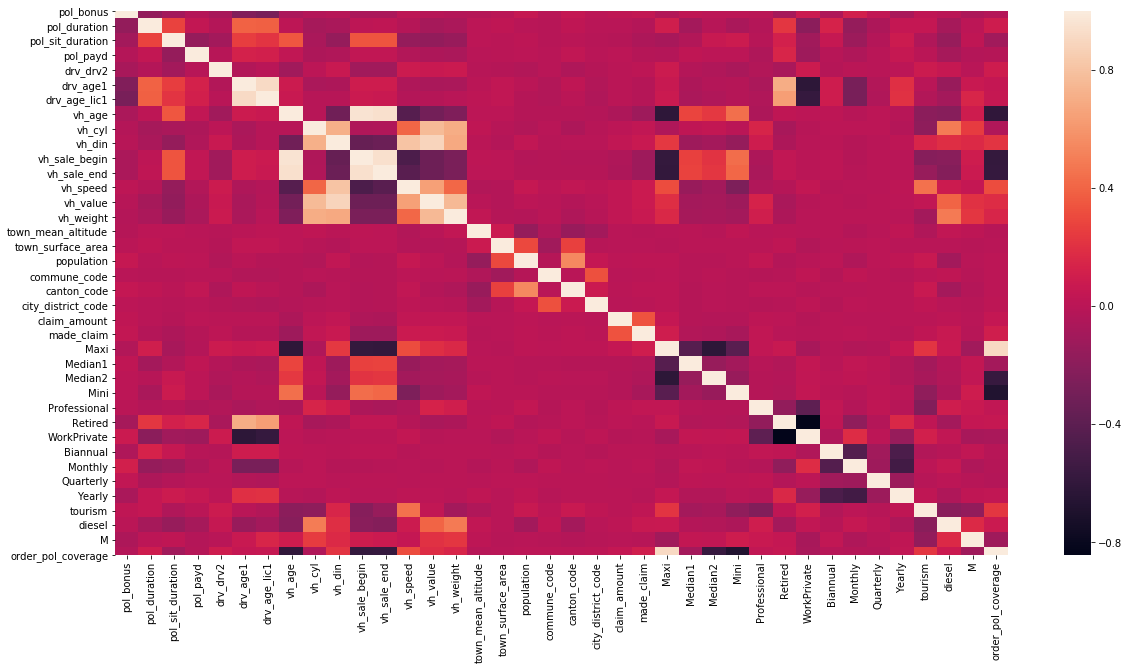

In [91]:
fig,ax = plt.subplots(figsize=(20,10))
sns.heatmap(df2.corr())

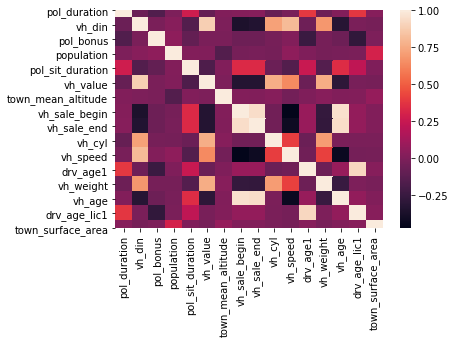

In [112]:
sns.heatmap(df2[numericFeatures].corr())

In [ ]:

temp = X4.corr()
for i in range(len(temp.columns)):
    temp.iloc[i,i] = 0
temp.abs().max()

#Clusters of correlation

# vh_value and vh_din and vh_speed and vh_cyl and vh_weight;

# vh_sale_begin and vh_age and vh_sale_end;

# drv_age_lic1 and drv_age1, Retired, WorkPrivate, Professional

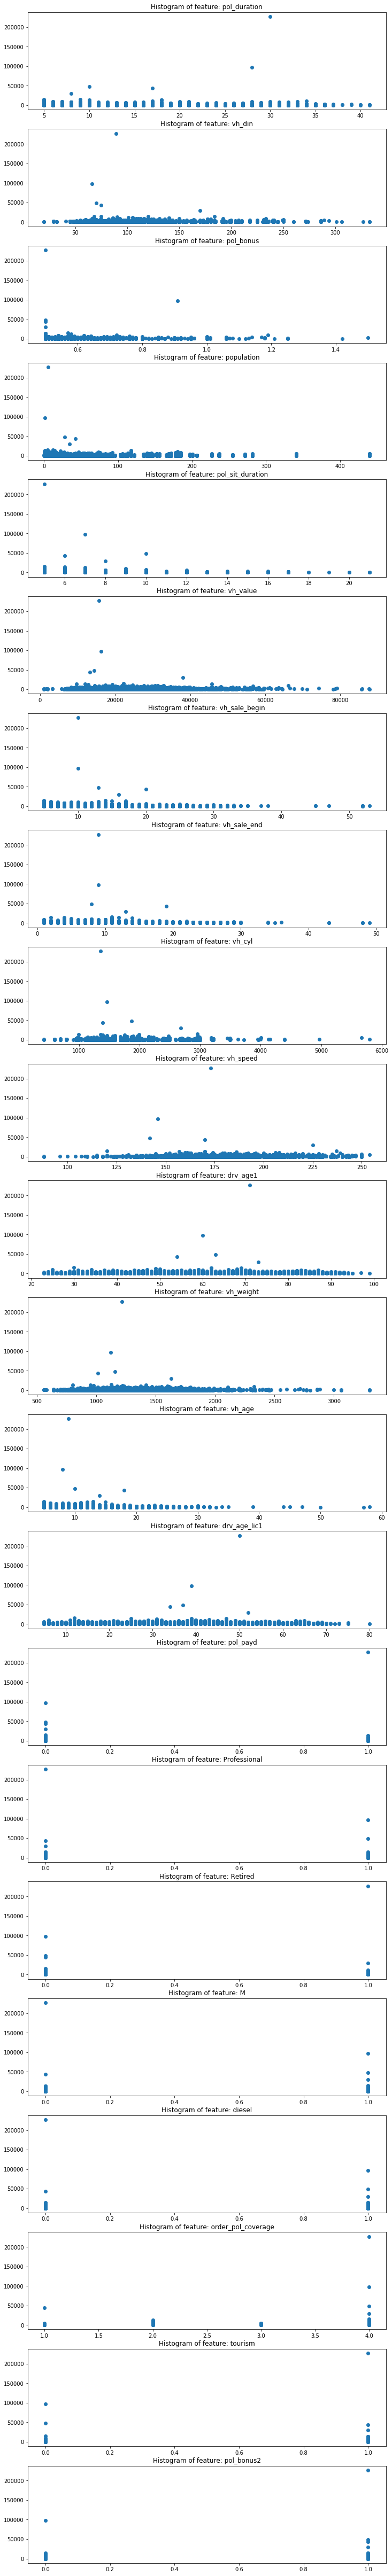

In [17]:
import matplotlib.gridspec as gridspec
plt.figure(figsize = (12, 120))
gs = gridspec.GridSpec(30, 1)
for i, cn in enumerate(df2[numericFeatures+booleanFeatures]):
    ax = plt.subplot(gs[i])    
    plt.scatter(x=cn,y='claim_amount',data=df2.loc[df2['made_claim']==1])
    ax.set_xlabel('')
    ax.set_title('Histogram of feature: ' + str(cn))
plt.show()


In [10]:
from sklearn.decomposition import PCA
X = df2[numericFeatures]
X = ((X-X.mean())/X.std())
pca = PCA()
X2 = pca.fit_transform(X)[:-4]

In [14]:
pca.explained_variance_ratio_

array([0.30925367, 0.16674449, 0.14731158, 0.07820657, 0.06115718,
       0.05606728, 0.05500324, 0.0426616 , 0.0401248 , 0.01716344,
       0.01058774])

In [20]:
from sklearn.cluster import DBSCAN,Birch,MiniBatchKMeans
cluster = MiniBatchKMeans(n_clusters=4)
cluster.fit(X2[:,:2])


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=4, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [9]:
booleanFeatures = ['drv_drv2','pol_payd','Maxi', 'Median1', 'Median2', 'Mini',
       'Professional', 'Retired','M','diesel','order_pol_coverage','tourism']+['order_pol_coverage'] # omitted - + ['vh_make','vh_model','canton_code','commune_code',city_district_code','regional_department_code','Biannual', 'Monthly',       'Quarterly']
numericFeatures = ['pol_duration', 'vh_din', 'pol_bonus', 'population', 'pol_sit_duration', 'vh_value', 'town_mean_altitude', 'vh_sale_begin', 'vh_sale_end', 'vh_cyl', 'vh_speed', 'drv_age1', 'vh_weight', 'vh_age', 'drv_age_lic1'] #+ ['order_pol_coverage','town_surface_area']

In [7]:
from sklearn.decomposition import PCA
pca = PCA()
X = pca.fit_transform(df2[['vh_age','vh_sale_begin','vh_sale_end']])
df2['pca_vh_ageFactors'] = X[:,:1]
df3 = df2[['pca_vh_ageFactors','made_claim']].drop_duplicates()
X = ((df3['pca_vh_ageFactors']-df3['pca_vh_ageFactors'].mean())/df3['pca_vh_ageFactors'].std()).values.reshape(-1,1)
y1 = df3['made_claim']
df2['pca_vh_ageFactors'].corr(df2['made_claim'])

-0.12147957791053285

In [ ]:
# #feature transformation
# from sklearn.preprocessing import PowerTransformer,QuantileTransformer,KBinsDiscretizer

# # transform = PowerTransformer(method='box-cox')
# transform = QuantileTransformer(output_distribution='uniform')
# # transform = KBinsDiscretizer(n_bins=25,encode='ordinal')
# X = transform.fit_transform(df2['vh_age'].values.reshape(-1,1))
# pd.DataFrame(X).corrwith(df2['made_claim'],method='pearson')

# #-0.125105 (Pearson) with  Quantile Transform and vh_age

In [ ]:
#plot correlation with marginal distribution of severity
for x in X3.columns:
    fig, ax = plt.subplots()
    ax.set_title(x)
    plt.scatter(X3.loc[y3.index,x],np.log(y3))